# 3. NY_Taxi_Fare_Prediction_with_DNN

## 3.1 Environment

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

# keras와 sklearn은 나중에 따로 임포트

## 3.2 Business Understanding

뉴욕의 상징이기도 한 노란 택시는 우버의 등장으로 인해 생존권에 막대한 위협을 받고 있다.

노란 택시는 우버에 밀리지 않기 위해 많은 것을 현대화하고자 한다.

그에 맞춰 앱을 출시하고 예상 금액을 고객들에게 미리 보여주고 싶다.

이러한 노란 택시의 Agony에 맞춰 DNN을 활용해 예상 택시 요금 예측 모델을 구축해보자.

## 3.3 Dataset

이번 프로젝트는 캐글에 공개된 뉴욕시 택시 요금 데이터셋을 사용한다. 노란 택시가 2009년부터 2015년까지 5,500만 회 운행한 기록이다.

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

## 3.4 EDA

음, 데이터셋의 크기가 어마무시합니다. 보통의 컴퓨터로는 불러들일 수조차 없다고 합니다. 그래서 일부만 불러옵니다. (애초에 트래인 데이터 하나가 5GB임 ㄷㄷ ㄷ)

In [3]:
df = pd.read_csv("ny_taxi_train.csv", parse_dates=["pickup_datetime"], nrows=500000) # 일부만 불러줍니다.

# parse_dates 로 칼럼을 지정해주면 datetime 으로 불러와줍니다.

In [4]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


Column Describtion

- Key : 네 그냥 키 값입니다.
- fare_amount : 운행 후 지불 요금. 이걸 맞춰야 합니다.
- pickup_datetime : 승차한 날짜와 시간
- pickup_longitude : 승차 위치(위도)
- pickup_latitude : 승차 위치(경도)
- dropoff_longitude : 하차 위치(위도)
- dropoff_latitude : 하차 위치(경도)
- passenger_count : 승객 수

### 3.4.1 Plot_lat_long

택시 요금은 운행 거리에 따라서 그 결과가 도출되기 때문에 데이터에 제공되는 승하차 위치를 점차트를 통해서 그려보도록 한다.

In [8]:
# 뉴욕을 벗어난 것은 제외하도록 하자.
# df2에 새로 넣어준다.

# 뉴욕시의 경도 범위
nyc_min_long = -74.05 # 대충 인터넷으로 찾을 수 있는 수치다.
nyc_max_long = -73.75

# 뉴욕시의 위도 범위
nyc_min_lat = 40.63
nyc_max_lat = 40.85

df2 = df.copy(deep=True)
for long in ["pickup_longitude", "dropoff_longitude"]:
    df2 = df2[(df2[long] > nyc_min_long) & (df2[long] < nyc_max_long)]
    
for lat in ["pickup_latitude", "dropoff_latitude"]:
    df2 = df2[(df2[lat] > nyc_min_lat) & (df2[lat] < nyc_max_lat)]

df2.shape

(483500, 8)

In [9]:
# 랜드마크 건설!

landmarks = {"JFK_Airport":(-73.78, 40.643),
            "Laguardia_Airport":(-73.87, 40.77),
            "Midtown":(-73.98, 40.76),
            "Lower_Manhattan":(-74.00, 40.72),
            "Upper_Manhattan":(-73.94, 40.82),
            "Brooklyn":(-73.95, 40.66)}

In [17]:
# plot을 그려봅시다.

def plot_lat_long(df, landmarks, points="Pickup"):
    plt.figure(figsize=(18, 18)) # 차트 사이즈 정의
    if points == "Pickup":
        plt.plot(list(df.pickup_longitude),
                 list(df.pickup_latitude),
                 '.',
                 markersize=1)
    else:
        plt.plot(list(df.dropoff_longitude),
                 list(df.dropoff_latitude),
                 '.',
                 markersize=1)
    for landmark in landmarks: #랜드마크 지도 위에 표시
        plt.plot(landmarks[landmark][0],
                 landmarks[landmark][1],
                 '*',
                 markersize=15,
                 alpha=1,
                 color='r') 
        plt.annotate(landmark, (landmarks[landmark][0]+0.005,
                                landmarks[landmark][1]+0.005),
                                color='r',
                                backgroundcolor='w')
    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

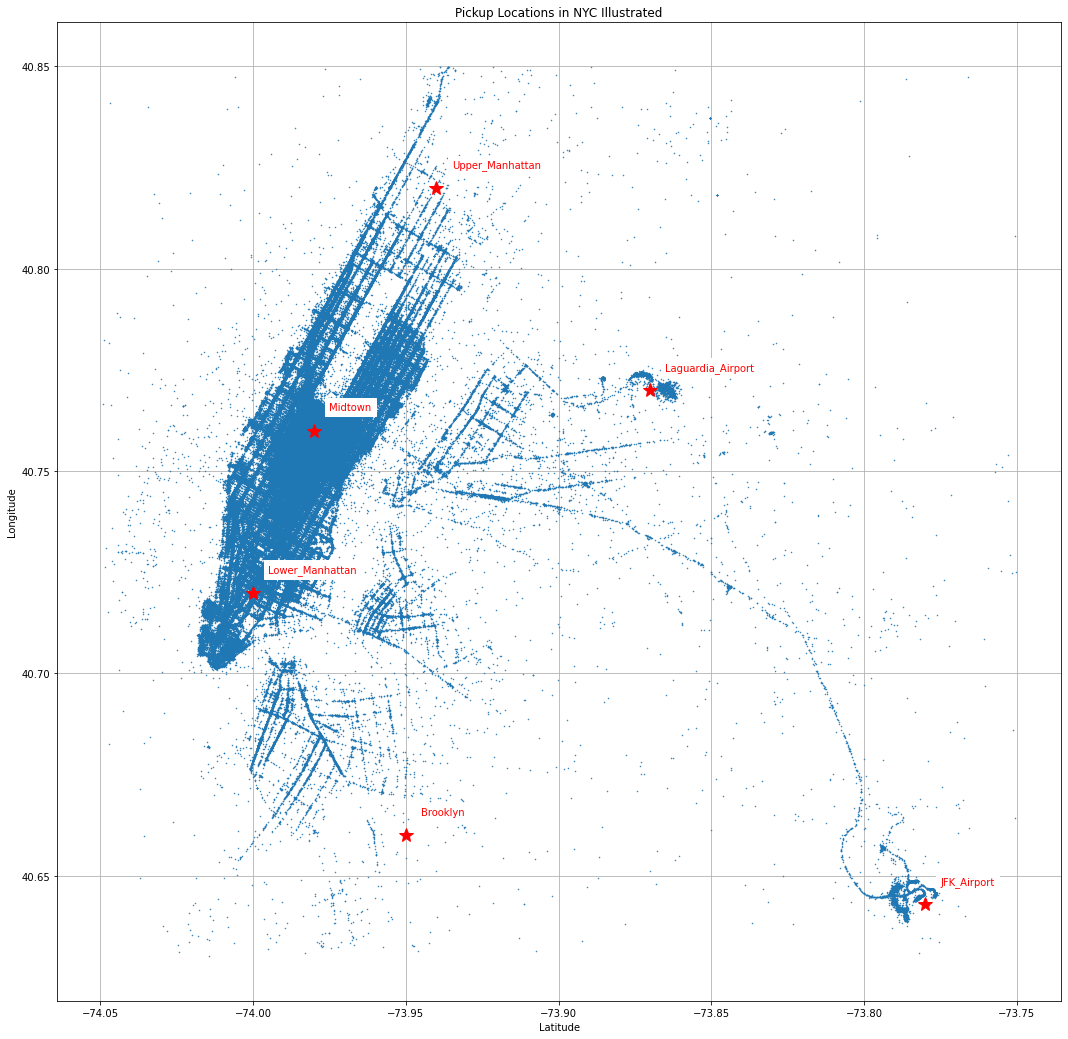

In [18]:
plot_lat_long(df2, landmarks, points="Pickup")

- 미드타운에서 가장 많이 타는 것으로 밝혀졌습니다. 공항도 꽤나 많이 탑니다. 로어 맨해튼도 많이 타는군요

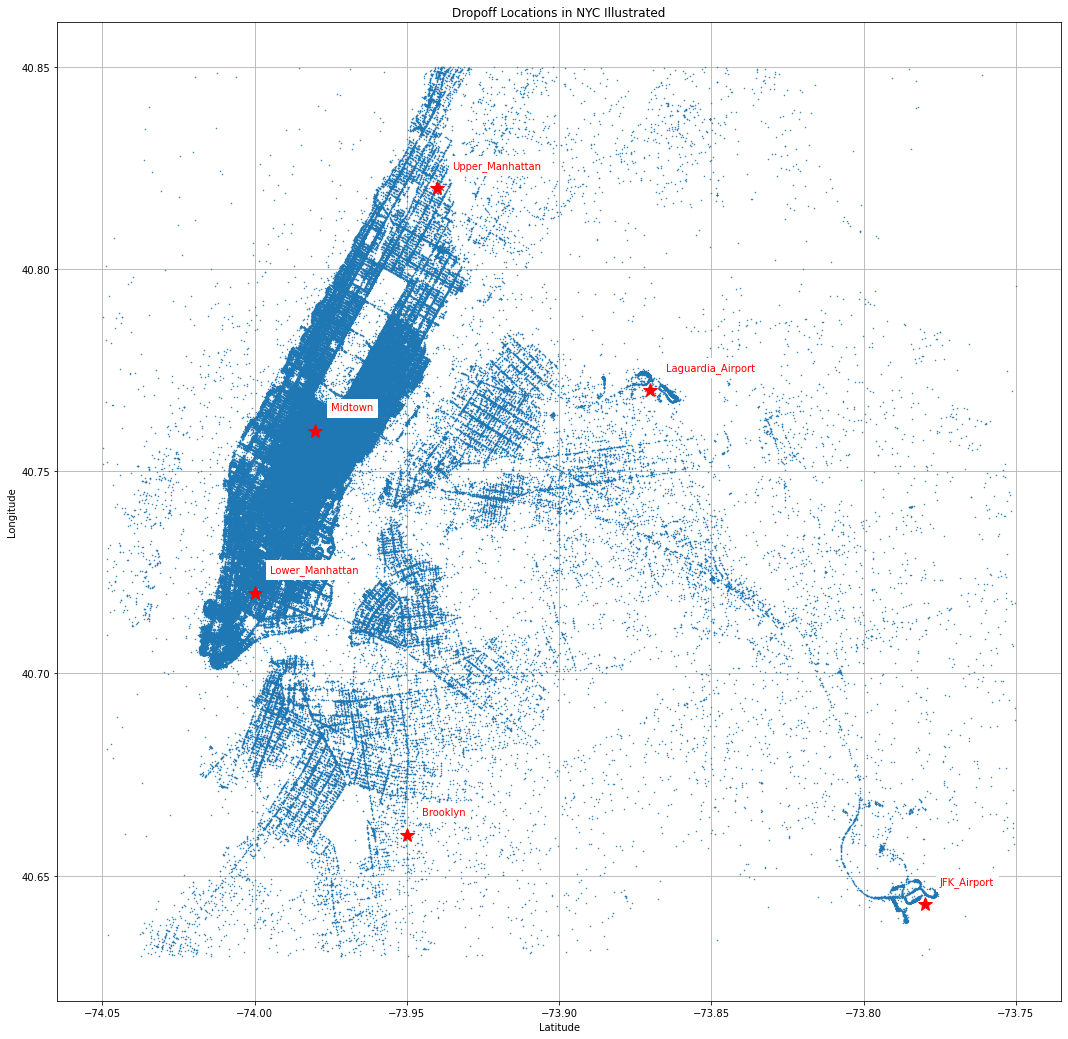

In [19]:
plot_lat_long(df2, landmarks, points="Dropoff")

- 내리는 건 조금 퍼져 있습니다. 브루클린으로도 많이 가고요. 어퍼 맨해튼도 많이 가네요!

### 3.4.2 Datetime

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483500 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                483500 non-null  object             
 1   fare_amount        483500 non-null  float64            
 2   pickup_datetime    483500 non-null  datetime64[ns, UTC]
 3   pickup_longitude   483500 non-null  float64            
 4   pickup_latitude    483500 non-null  float64            
 5   dropoff_longitude  483500 non-null  float64            
 6   dropoff_latitude   483500 non-null  float64            
 7   passenger_count    483500 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 33.2+ MB


불러올 때 datetime으로 불러왔습니다. 아니라면 pandas 에 있는 pd.to_datetime() 으로 바꿔주면 됩니다.

In [21]:
# datetime을 연월일시 등으로 나눠줍니다.

df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["hour"] = df["pickup_datetime"].dt.hour

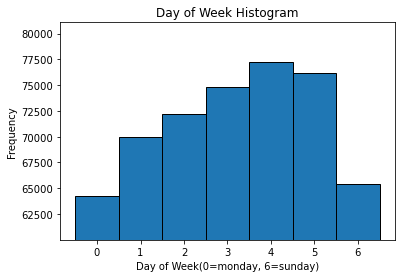

In [23]:
# 요일별로 승차 빈도수를 살펴봅니다.

df["day_of_week"].plot.hist(bins=np.arange(8)-0.5, ec='black', ylim=(60000.75000))
plt.xlabel("Day of Week(0=monday, 6=sunday)")
plt.title("Day of Week Histogram")
plt.show()

월요일과 일요일엔 잘 안 탑니다. 금요일로 갈수록 많이 타네요!

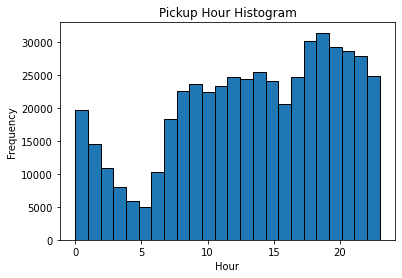

In [24]:
# 시간별로 승차 빈도수를 살펴봅니다.

df["hour"].plot.hist(bins=24, ec='black')
plt.xlabel("Hour")
plt.title("Pickup Hour Histogram")
plt.show()

역시 퇴근 시간에 가장 많이 탑니다.

## 3.5 Preprocessing

In [27]:
# 먼저 결측값을 확인합니다.

df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64

In [28]:
# 결측값이 많지 않으니 그냥 drop 합니다.

df = df.dropna()

In [29]:
# 기초 통계량을 조사해봅니다.

df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000,499995.000000
mean,11.358182,-72.520091,39.920350,-72.522435,39.916526,1.683445,2011.739129,6.268617,15.684239,3.042020,13.510843
std,9.916069,11.856446,8.073318,11.797362,7.391002,1.307391,1.860897,3.437798,8.681092,1.949243,6.511596
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992047,40.734916,-73.991382,40.734057,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


값이 아주 흥미진진합니다. fare 에서 -44불은 뭐고, 500불은 뭐죠.. 위도경도에서 -3000은 뭐죠. passenger_count 도 0이 있네요?!

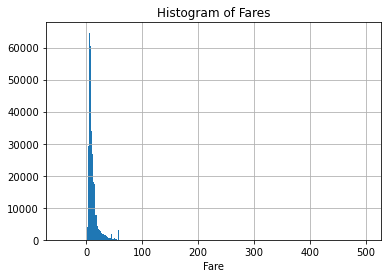

In [30]:
df["fare_amount"].hist(bins=500)
plt.xlabel("Fare")
plt.title("Histogram of Fares")
plt.show()

In [31]:
# fare 가 0달러보다 작거나 100달러보다 큰 요금을 가진 row 는 제거하겠습니다.

df = df[(df["fare_amount"] >=0) & (df["fare_amount"] <= 100)] 

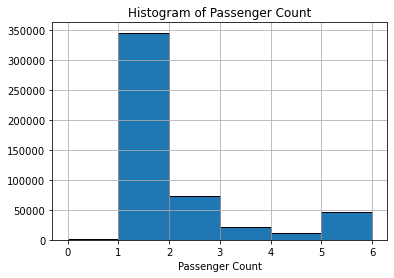

In [32]:
# 패신저 카운트를 봐봅니다.

df["passenger_count"].hist(bins=6, ec='black')
plt.xlabel("Passenger Count")
plt.title("Histogram of Passenger Count")
plt.show()

In [33]:
# 0명은 그냥 1명으로 바꿔줍니다.

df.loc[df["passenger_count"] == 0, "passenger_count"] = 1

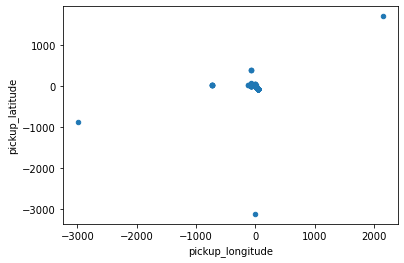

In [34]:
# 위치에도 이상치 있는 것 같아요.

df.plot.scatter("pickup_longitude", "pickup_latitude")
plt.show()

In [35]:
# 뉴욕을 벗어난 것은 제외하도록 하자.
# 아까 EDA에서 썼던 코드 고대로 가져오자

# 뉴욕시의 경도 범위
nyc_min_long = -74.05 # 대충 인터넷으로 찾을 수 있는 수치다.
nyc_max_long = -73.75

# 뉴욕시의 위도 범위
nyc_min_lat = 40.63
nyc_max_lat = 40.85

for long in ["pickup_longitude", "dropoff_longitude"]:
    df = df[(df[long] > nyc_min_long) & (df[long] < nyc_max_long)]
    
for lat in ["pickup_latitude", "dropoff_latitude"]:
    df = df[(df[lat] > nyc_min_lat) & (df[lat] < nyc_max_lat)]

df.shape

(483438, 13)

## 3.6 Feature Engineering

### 3.6.1 datetime feature

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483438 entries, 0 to 499999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                483438 non-null  object             
 1   fare_amount        483438 non-null  float64            
 2   pickup_datetime    483438 non-null  datetime64[ns, UTC]
 3   pickup_longitude   483438 non-null  float64            
 4   pickup_latitude    483438 non-null  float64            
 5   dropoff_longitude  483438 non-null  float64            
 6   dropoff_latitude   483438 non-null  float64            
 7   passenger_count    483438 non-null  int64              
 8   year               483438 non-null  int64              
 9   month              483438 non-null  int64              
 10  day                483438 non-null  int64              
 11  day_of_week        483438 non-null  int64              
 12  hour               483438 non-

EDA 과정에서 이미 만들어버렸다. 기존 datetime column만 없애주자. 얘는 어따 쓰지도 못한다.

In [37]:
df.drop("pickup_datetime", axis=1, inplace=True)

### 3.6.2 distance feature

승하차 위치 정보를 통해서 거리를 추정해보겠습니다.

책에서는 유클리디안 거리를 택했지만, 저는 맨해튼 디스턴스를 택하겠습니다. 맨해튼에선 맨해튼이죠.

 - formula = |a - c| + |b - d|

In [38]:
def manhattan_dis(lat_a, long_b, lat_c, long_d):
    dis = abs(lat_a - lat_c) + abs(long_b - long_d)
    return dis

In [39]:
df["distance"] = manhattan_dis(df["pickup_latitude"],
                              df["pickup_longitude"],
                              df["dropoff_latitude"],
                              df["dropoff_longitude"])

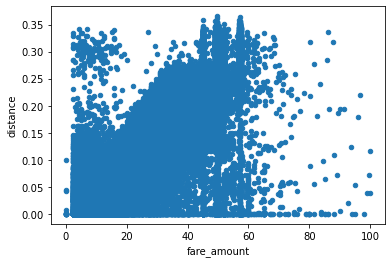

In [40]:
df.plot.scatter("fare_amount", "distance")
plt.show()

40달러와 60달러 사이에 세 개의 요금 기둥이 있다. 공항을 기점으로 하는 정액 요금이라고 본다.

In [42]:
# 뉴욕시의 세 주요 공항과 승차 및 하차 위치 사이의 거리를 계산하자

airports = {"JFK":(-73.78, 40.643),
          "Laguardia":(-73.87, 40.77),
          "Newark":(-74.18, 40.69)}

In [43]:
for airport in airports:
    # 승차 위치와 공항 위치와의 거리 계산
    df["pickup_dist_" + airport] = manhattan_dis(df["pickup_latitude"],
                                                df["pickup_longitude"],
                                                airports[airport][1],
                                                airports[airport][0])
    
    # 하차 위치와 공항 위치와의 거리 계산
    df["dropoff_dist_" + airport] = manhattan_dis(df["dropoff_latitude"],
                                                df["dropoff_longitude"],
                                                airports[airport][1],
                                                airports[airport][0])

In [45]:
# 필요없는 key는 지워주자.

df.drop("key", axis=1, inplace=True)

In [46]:
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK,dropoff_dist_JFK,pickup_dist_Laguardia,dropoff_dist_Laguardia,pickup_dist_Newark,dropoff_dist_Newark
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,0.011742,0.142630,0.130888,0.074370,0.086112,0.367008,0.360668
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,0.107481,0.304351,0.338272,0.204745,0.121272,0.185255,0.292736
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,0.019212,0.321008,0.318804,0.121468,0.140680,0.268532,0.249320
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,0.029386,0.297273,0.326659,0.153987,0.133475,0.236013,0.256525
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,0.027194,0.313103,0.317417,0.100087,0.100417,0.289913,0.317107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,7.0,-73.978775,40.766724,-73.966072,40.758537,1,2015,5,7,3,18,0.020889,0.322499,0.301609,0.112051,0.107535,0.277949,0.282465
499996,13.7,-74.002932,40.718408,-74.009442,40.710952,1,2010,9,13,0,12,0.013966,0.298340,0.297394,0.184524,0.198490,0.205476,0.191510
499997,25.0,-73.983885,40.725611,-73.896482,40.700980,1,2014,8,25,0,0,0.112034,0.286496,0.174462,0.158274,0.095502,0.231726,0.294498
499998,6.5,-73.974617,40.756512,-73.970184,40.764801,6,2015,1,12,0,12,0.012722,0.308129,0.311985,0.118105,0.105383,0.271895,0.284617


## 3.7 Feature Scaling

책의 방법을 써봅시다

In [72]:
df_prescaled = df.copy()

In [73]:
df_scaled2 = df.drop(["fare_amount"], axis=1)

In [74]:
from sklearn.preprocessing import scale

In [75]:
df_scaled2 = scale(df_scaled2)

In [76]:
cols = df.columns.tolist()

In [77]:
cols.remove("fare_amount")

In [79]:
df_scaled2 = pd.DataFrame(df_scaled2, columns=cols, index=df.index)
df_scaled2 = pd.concat([df_scaled2, df["fare_amount"]], axis=1)
df_scaled2

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,distance,pickup_dist_JFK,dropoff_dist_JFK,pickup_dist_Laguardia,dropoff_dist_Laguardia,pickup_dist_Newark,dropoff_dist_Newark,fare_amount
0,3.916896,-1.128227,4.151116,-1.365537,-0.526888,-1.469611,-0.078187,-0.078219,-1.560801,0.535442,-0.650927,-3.751391,-4.245044,-1.627444,-1.285938,2.202971,2.019176,4.5
1,-1.203464,-1.510227,-0.146055,1.083475,-0.526888,-0.932852,-1.531625,-1.230176,-1.047515,0.381408,1.374404,0.017182,0.876062,2.006249,-0.308278,-1.788649,0.537864,16.9
2,-0.210322,0.395464,-0.519838,-0.020874,0.239932,-0.396092,0.503188,0.267369,-0.020945,-2.083145,-0.492902,0.405339,0.395322,-0.314772,0.231382,0.040262,-0.408857,5.7
3,-0.341270,-0.677271,-0.529984,0.243605,-0.526888,0.140667,-0.659562,0.612956,1.005625,-1.467007,-0.277674,-0.147756,0.589293,0.591568,0.031039,-0.673913,-0.251746,7.7
4,0.226261,0.652445,0.559839,1.145221,-0.526888,-0.932852,-0.950250,-0.769393,-1.047515,-1.004903,-0.324045,0.221129,0.361072,-0.910683,-0.888173,0.509827,1.069294,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-0.092166,0.603461,0.265873,0.259245,-0.526888,1.750944,-0.368875,-0.999784,-0.020945,0.689477,-0.457419,0.440076,-0.029279,-0.577223,-0.690255,0.247068,0.313901,7.0
499996,-0.812409,-1.239249,-1.087975,-1.412111,-0.526888,-0.932852,0.793875,-0.308610,-1.560801,-0.234731,-0.603879,-0.122892,-0.133372,1.442668,1.838849,-1.344560,-1.669451,13.7
499997,-0.244520,-0.964534,2.438216,-1.762361,-0.526888,1.214185,0.503188,1.073739,-1.560801,-2.083145,1.470721,-0.398892,-3.169035,0.711052,-1.024840,-0.768063,0.576286,25.0
499998,0.031806,0.213987,0.137504,0.479248,3.307214,1.750944,-1.531625,-0.423806,-1.560801,-0.234731,-0.630195,0.105214,0.226944,-0.408493,-0.750080,0.114113,0.360816,6.5


In [80]:
df = df_scaled2.copy()

## 3.8 DNN

- 히든 레이어를 4개 사용하는 DNN 모델이다.
- 활성화 함수는 ReLU를 사용한다.
- 출력 레이어는 회귀 모델이므로 1개의 노드만 출력한다.

손실함수는 RMSE 를 사용한다.

루트 민 스퀘어드 에러 이다.

말 그대로 오차를 제곱한 값의 평균의 제곱근.

## 3.9 Modeling with Keras

In [82]:
# train test split

x = df.loc[:, df.columns != "fare_amount"]
y = df.loc[:, "fare_amount"]

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((386750, 17), (96688, 17), (386750,), (96688,))

In [86]:
# 모델링 합니다.

from keras.models import Sequential
from keras.layers import Dense

In [88]:
# 먼저 뼈대 잡습니다.
model = Sequential()

# 레이어 얹습니다.
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

In [89]:
# 모델 구조 확인합니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 12,913
Trainable params: 12,913
Non-trainable params: 0
_________________________________________________________________


In [90]:
# 컴파일 합니다.

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs=1) # 데이터가 크니 에포크는 1로....

Epoch 1/1
386750/386750 [==============================] - 29s 74us/step - loss: 14.2410 - mse: 14.2410


mse 14.24 가 나왔습니다. 책보다 살짝 좋은 성능이네요!

## 3.10 Evaluation

테스트 데이터셋에서 무작위로 샘플을 뽑아 요금을 예측하는 함수를 만들어봅니다.

In [93]:
def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0, high=10000))
    idx = sample.index[0]
    actual_fare = df_prescaled.loc[idx, "fare_amount"]
    
    day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    day_of_week = day_names[df_prescaled.loc[idx, "day_of_week"]]
    hour = df_prescaled.loc[idx, "hour"]
    
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare-actual_fare))
    
    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour))
    print("Actual Fare: ${:0.2f}".format(actual_fare))
    print("Predicted Fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

In [94]:
predict_random(df_prescaled, X_test, model)

Trip Details: Sun, 12:00hrs
Actual Fare: $7.50
Predicted Fare: $7.68
RMSE: $0.18


In [95]:
predict_random(df_prescaled, X_test, model)

Trip Details: Tue, 8:00hrs
Actual Fare: $22.50
Predicted Fare: $12.17
RMSE: $10.33


In [96]:
predict_random(df_prescaled, X_test, model)

Trip Details: Fri, 10:00hrs
Actual Fare: $6.00
Predicted Fare: $6.56
RMSE: $0.56


In [97]:
predict_random(df_prescaled, X_test, model)

Trip Details: Fri, 11:00hrs
Actual Fare: $7.30
Predicted Fare: $7.25
RMSE: $0.05


In [98]:
predict_random(df_prescaled, X_test, model)

Trip Details: Mon, 0:00hrs
Actual Fare: $5.30
Predicted Fare: $5.10
RMSE: $0.20


In [99]:
predict_random(df_prescaled, X_test, model)

Trip Details: Sat, 14:00hrs
Actual Fare: $13.70
Predicted Fare: $13.91
RMSE: $0.21


In [100]:
predict_random(df_prescaled, X_test, model)

Trip Details: Sat, 11:00hrs
Actual Fare: $17.00
Predicted Fare: $19.01
RMSE: $2.01


이제 전체 훈련 셋과 테스트 데이터 셋으로 계산해봅니다.

In [101]:
from sklearn.metrics import mean_squared_error

In [102]:
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

In [103]:
test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

In [104]:
print("Train_RMSE: {:0.2f}".format(train_rmse))
print("Test_RMSE: {:0.2f}".format(test_rmse))

Train_RMSE: 3.53
Test_RMSE: 3.57


3.57이 나오네요..!! 이정도면 캐글 1400팀 중에 딱 절반 수준입니다. 2.5 언더로 내려가면 3등 안에 듭니다.

아마도 트래픽잼을 생각해야 할 것이고

기본 요금도 생각해야 할 것이고

이런저런 파생변수가 많겠죠!